## Layer-Wise Relevance Propagation Numpy Implementation
Mirror notebook of - https://git.tu-berlin.de/gmontavon/lrp-tutorial/-/blob/main/tutorial.ipynb
<br>
Overview paper - https://link.springer.com/chapter/10.1007%2F978-3-030-28954-6_10
<br><br>
Based on a simple deep rectifier network trained on the MNIST handwritten digits data
<br><br><br>
#### Loading 12 example MNIST digits

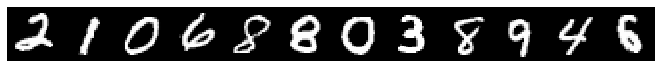

In [2]:
import util
X,T = util.loaddata()

%matplotlib inline
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

Each digit is stored as a 784-dimensional vector of pixel values, where "-1.0" corresponds to black and "+1.0" corresponds to white.


#### Predicting classes of MNIST digits
We retrieve the parameters of a fully connected neural network with layer sizes 784-300-100-10 with ReLU activations for each hidden layer.

This network acieves an error of 1.6%.

In [3]:
W,B = util.loadparams()
L = len(W) 

Computing the forward pass (sequence of matric multiplications and nonlinearities)

In [4]:
import numpy
A = [X]+[None]*L
for l in range(L):
    A[l+1] = numpy.maximum(0,A[l].dot(W[l])+B[l])

Note that this code has added an additional top-layer ReLU activation compared to the original neural network. This however doesn't affect computations when looking at positive output scores. The top layer activations are scores measuring the evidence the network has found for each class. 
<br><br>
Checking the first three digits and scores for each class:

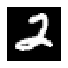

[0] 0.0  [1] 3.6  [2] 49.1  [3] 8.9  [4] 0.0  [5] 0.0  [6] 0.0  [7] 1.4  [8] 1.6  [9] 0.0


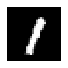

[0] 0.0  [1] 27.0  [2] 0.0  [3] 0.0  [4] 5.3  [5] 0.0  [6] 0.0  [7] 13.0  [8] 8.1  [9] 2.3


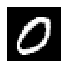

[0] 49.1  [1] 0.0  [2] 10.6  [3] 0.0  [4] 0.0  [5] 0.2  [6] 0.0  [7] 3.0  [8] 0.0  [9] 9.2


In [5]:
for i in range(3):
    util.digit(X[i].reshape(28,28),0.75,0.75)
    p = A[L][i]
    print("  ".join(['[%1d] %.1f'%(d,p[d]) for d in range(10)]))

#### Explaining the above predictions using LRP

We implement the LRP procedure from the top to the bottom of the network in the following steps:
<br><br>
1.Create a list to store relevance scores at each level. The top-level scores are set to the top-layer activations which are multiplies by a label indicator to retain only the actual class evidence.

In [6]:
 R = [None]*L + [A[L]*(T[:,None]==numpy.arange(10))]

The LRP-0, LRP-ϵ, and LRP-γ rules described in the overview paper (Section 10.2.1) are special cases of the more general propagation rule - 

<img src="http://latex.codecogs.com/svg.latex?R_j = \sum_k \frac{a_j \rho(w_{jk})}{\epsilon + \sum_{0,j} a_j \rho(w_{jk})} R_k">

where ρ is a function that transform the weights, and ϵ is a small positive increment. 
<br>
We define two helper functions that perform the weight transformation and the incrementation. In practice, we would like to apply different rules at different layers (Section 10.3). Therefore, we also give the layer index "<code>l</code>" as argument to these functions.

In [7]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * numpy.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

These functions helps us to reduce the general rule to LRP-0 for the top-layer, to LRP-ϵ with ϵ = 0.1std for the layer just below, and to LRP-γ with γ=0.1 for the layer before.
<br><br> 
The general rule can be decomposed to a sequence of four computations:

<p>
<img src="http://latex.codecogs.com/svg.latex?
\begin{align*}
\forall_k:~z_k = {\textstyle \epsilon + \sum_{0,j}} a_j \rho(w_{jk}) & (\text{step }1)\\
\forall_k:~s_k = R_k / z_k \qquad & (\text{step }2)\\
\forall_j:~c_j = {\textstyle \sum_k} \rho(w_{jk}) s_k \qquad & (\text{step }3)\\
\forall_j:~R_j = a_j \cdot c_j \qquad & (\text{step }4)
\end{align*}
">
</p>
<br><br>
We iterate over the layers in reverse order, and at each layer apply the above mentioned sequence of computations.

In [8]:
for l in range(1,L)[::-1]:

    w = rho(W[l],l)
    b = rho(B[l],l)
    
    z = incr(A[l].dot(w)+b,l)    # step 1
    s = R[l+1] / z               # step 2
    c = s.dot(w.T)               # step 3
    R[l] = A[l]*c                # step 4

**Important**<br>
The loop above stops one layer before the pixels because we need to apply an alternate propagation rule that properly handles pixel values received as input (section 10.3.2). We apply the following zB-rule described by:<br>
<img src="http://latex.codecogs.com/svg.latex?R_i = \sum_j \frac{a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-}{\sum_{i} a_i w_{ij} - l_i w_{ij}^+ - h_i w_{ij}^-} R_j">


<p>In this rule, <i>l<sub>i</sub></i> and <i>h<sub>i</sub></i> are the lower and upper bounds of pixel values, i.e. "-1" and "+1", and (·)<sup>+</sup> and (·)<sup>–</sup> are shortcut notations for max(0,·) and min(0,·). The zB-rule can again be implemented with a four-step procedure similar to the one used in the other layers. Here, we need to create two copies of the weights, and also create arrays of pixel values set to <i>l<sub>i</sub></i> and <i>h<sub>i</sub></i> respectively:</p>

In [9]:
w  = W[0]
wp = numpy.maximum(0,w)
wm = numpy.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.T),s.dot(wp.T),s.dot(wm.T)     # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

We have now reached the bottom layer and the pixel-wise relevance scores have been obtained and can be rendered as a heatmap.

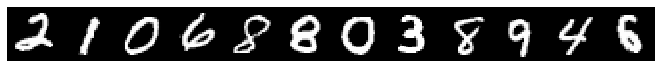

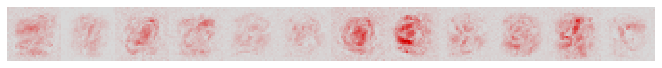

In [10]:
util.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
util.heatmap(R[0].reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

Relevant pixels are highlighted in red. Pixels that contribute negatively to the prediction, if any, are shown in blue. On most digits, we find that the digit itself is highlighted, as well as some parts of the background. For example, two red horizontal bars next to the digit "3", highlighting the fact that if those pixels would be different, the digit 3 would likely turn into a "8". Same for the vertical bar above the digit "4" that supports the class "4" instead of the class "9".